## Using Colab to conduct Kaggle Competition

###references:

1. https://medium.com/@erdemalpkaya/run-kaggle-kernel-on-google-colab-1a71803460a9

2. https://blog.gtwang.org/programming/keras-resnet-50-pre-trained-model-build-dogs-cats-image-classification-system/

3. https://www.kaggle.com/c/dogs-vs-cats/


## Setting the Pre-requirement for Using Colab

### Accquire Google Drive Authorization

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


### Upload Kaggle API (for downloading the Kaggle dataset)

In [0]:
from google.colab import files
uploaded = files.upload()

Saving kaggle.json to kaggle.json


### Set up Kaggle Package (for using Kaggle.json)

In [0]:
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
# we need to set permissions 
!chmod 600 /root/.kaggle/kaggle.json

In [0]:
### Locate the folder
import os
os.chdir('/content/gdrive/Shared drives/My Colab/Keras - dogs or cats')
!pwd

### Download Dataset and Set up Dataset (train & valid set)

In [0]:
!kaggle competitions download -c dogs-vs-cats

In [0]:
!unzip train.zip

In [0]:
!pwd

In [0]:
!mkdir -p sample/train/cats
!mkdir -p sample/train/dogs
!mkdir -p sample/valid/cats
!mkdir -p sample/valid/dogs

In [0]:
os.chdir('/content/gdrive/Shared drives/My Colab/Keras - dogs or cats/train')
# cd train
!cp cat.?.jpg cat.??.jpg cat.???.jpg ../sample/train/cats/
!cp dog.?.jpg dog.??.jpg dog.???.jpg ../sample/train/dogs/
!cp cat.1[0-3]??.jpg ../sample/valid/cats/
!cp dog.1[0-3]??.jpg ../sample/valid/dogs/

In [0]:
### Locate the folder
os.chdir('/content/gdrive/Shared drives/My Colab/Keras - dogs or cats')

##  Training Data (using Keras)

In [0]:
from tensorflow.python.keras import backend as K
from tensorflow.python.keras.models import Model
from tensorflow.python.keras.layers import Flatten, Dense, Dropout
from tensorflow.python.keras.applications.resnet50 import ResNet50
from tensorflow.python.keras.optimizers import Adam
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator

# data path (where your data is)
DATASET_PATH  = 'sample'

# model settings
IMAGE_SIZE = (224, 224)
NUM_CLASSES = 2
BATCH_SIZE = 8
FREEZE_LAYERS = 2
NUM_EPOCHS = 20

# your output model
WEIGHTS_FINAL = 'model-resnet50-final.h5'

# data augmentation 
train_datagen = ImageDataGenerator(rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   channel_shift_range=10,
                                   horizontal_flip=True,
                                   fill_mode='nearest')

train_batches = train_datagen.flow_from_directory(DATASET_PATH + '/train',
                                                  target_size=IMAGE_SIZE,
                                                  interpolation='bicubic',
                                                  class_mode='categorical',
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE)

valid_datagen = ImageDataGenerator()
valid_batches = valid_datagen.flow_from_directory(DATASET_PATH + '/valid',
                                                  target_size=IMAGE_SIZE,
                                                  interpolation='bicubic',
                                                  class_mode='categorical',
                                                  shuffle=False,
                                                  batch_size=BATCH_SIZE)

# print classes
for cls, idx in train_batches.class_indices.items():
    print('Class #{} = {}'.format(idx, cls))

# utilized pre-trained ResNet50 as model
# discard ResNet50 fully connected layers
net = ResNet50(include_top=False, weights='imagenet', input_tensor=None,
               input_shape=(IMAGE_SIZE[0],IMAGE_SIZE[1],3))
x = net.output
x = Flatten()(x)

# add DropOut layer
x = Dropout(0.5)(x)

# add Dense layer with softmax
output_layer = Dense(NUM_CLASSES, activation='softmax', name='softmax')(x)


net_final = Model(inputs=net.input, outputs=output_layer)
for layer in net_final.layers[:FREEZE_LAYERS]:
    layer.trainable = False
for layer in net_final.layers[FREEZE_LAYERS:]:
    layer.trainable = True

# Adam optimizer with low learning rate to operate fine-tuning
net_final.compile(optimizer=Adam(lr=1e-5),
                  loss='categorical_crossentropy', metrics=['accuracy'])

# print the model
print(net_final.summary())

# training
net_final.fit_generator(train_batches,
                        steps_per_epoch = train_batches.samples // BATCH_SIZE,
                        validation_data = valid_batches,
                        validation_steps = valid_batches.samples // BATCH_SIZE,
                        epochs = NUM_EPOCHS)

# save our model
net_final.save(WEIGHTS_FINAL)

In [0]:
# from tensorflow.python.keras import backend as K
# from tensorflow.python.keras.models import Model
# from tensorflow.python.keras.layers import Flatten, Dense, Dropout
# from tensorflow.python.keras.applications.resnet50 import ResNet50
# from tensorflow.python.keras.optimizers import Adam
# from tensorflow.python.keras.preprocessing.image import ImageDataGenerator

### Locate the folder
os.chdir('/content/gdrive/Shared drives/My Colab/Keras - dogs or cats/train')

## Predict (using the model we have trained)

### Predict all the pictures (loop through all the images in the folder)

In [0]:
from tensorflow.python.keras import backend as K
from tensorflow.python.keras.models import load_model
from tensorflow.python.keras.preprocessing import image
import sys
import numpy as np

directory = os.fsencode('/content/gdrive/Shared drives/My Colab/Keras - dogs or cats/train')

# load trained model
net = load_model('../model-resnet50-final.h5')

cls_list = ['cats', 'dogs']

# predict all photos (loop though the folder)
for f in os.listdir(directory):
    f = os.fsdecode(f)
    img = image.load_img('/content/gdrive/Shared drives/My Colab/Keras - dogs or cats/train/'+ str(f), target_size=(224, 224))
    if img is None:
        continue
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis = 0)
    pred = net.predict(x)[0]
    top_inds = pred.argsort()[::-1][:5]
    print(f)
    for i in top_inds:
        print('    {:.3f}  {}'.format(pred[i], cls_list[i]))

### Predict each pictures using def function

In [0]:
%pylab inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow.python.keras import backend as K
from tensorflow.python.keras.models import load_model
from tensorflow.python.keras.preprocessing import image
import sys
import numpy as np

def predict(image_path, model_path):
  
  img_show = mpimg.imread(image_path)
  imgplot = plt.imshow(img_show)
  plt.show()
  
  img = image.load_img(image_path, target_size=(224, 224))
  model = load_model(model_path)
  
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis = 0)
  
  pred = model.predict(x)[0]
  top_inds = pred.argsort()[::-1][:5]

  for i in top_inds:
    
    print('    {:.3f}  {}'.format(pred[i], cls_list[i]))

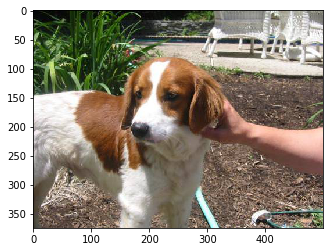

    1.000  dogs
    0.000  cats


In [0]:
### Def function uusage demo

image_path = '/content/gdrive/Shared drives/My Colab/Keras - dogs or cats/train/dog.1.jpg'
model_path = '../model-resnet50-final.h5'

predict(image_path, model_path)